In [2]:
# packages

# standard
import numpy as np
import pandas as pd
import time

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# statistics tools
from statsmodels.graphics.mosaicplot import mosaic

# ML
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator

 # Import Dataset

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
# dimensions of data
df.shape

(5110, 12)

In [5]:
# column names
print(df.columns.tolist())

['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


# Handling Missing Values

In [6]:
data_1=df.copy()
data_1.isnull().sum() 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# impute with -99
df.bmi = df.bmi.fillna(-99)

In [8]:
data_1=df.copy()
data_1.isnull().sum() 

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [33]:
# define target variable
df['target'] = df.stroke
df = df.drop(['stroke'], axis=1) # remove stroke column

AttributeError: 'DataFrame' object has no attribute 'stroke'

# Numerical Features

In [10]:
# select numerical features
features_num = ['age', 'avg_glucose_level','bmi']
# basic stats
df[features_num].describe()


,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,23.862603
std,22.612647,45.283560,26.028009
min,0.080000,55.120000,-99.000000
25%,25.000000,77.245000,22.900000
50%,45.000000,91.885000,27.700000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


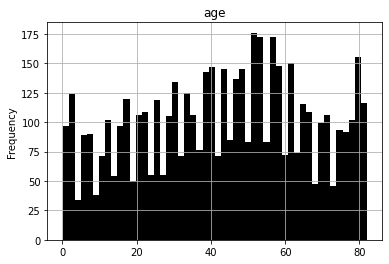

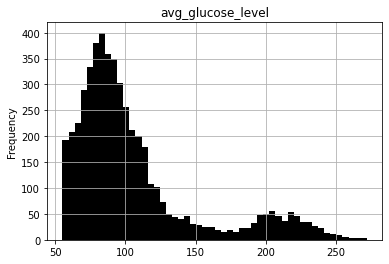

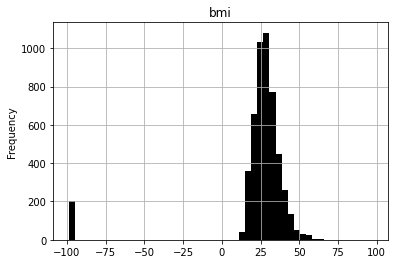

In [11]:
# plot distribution of numerical features
for f in features_num:
    df[f].plot(kind='hist', bins=50,color='black')
    plt.title(f)
    plt.grid()
    plt.show()

# Categorical Features

In [12]:
# rename columns
df.rename(columns = {'Residence_type':'residence_type'}, inplace = True)

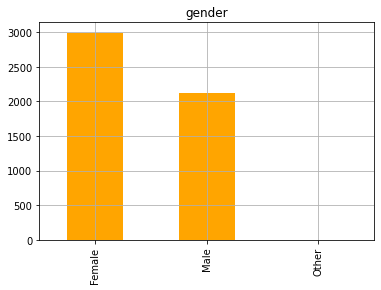

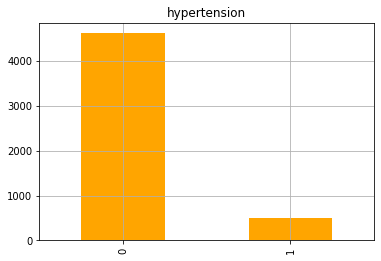

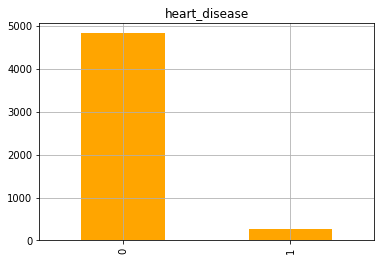

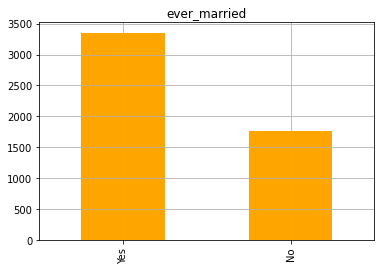

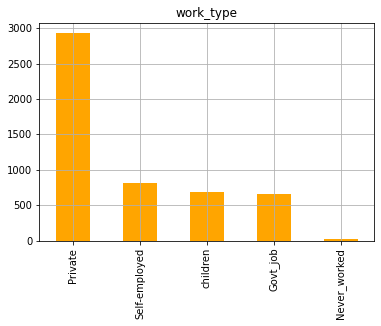

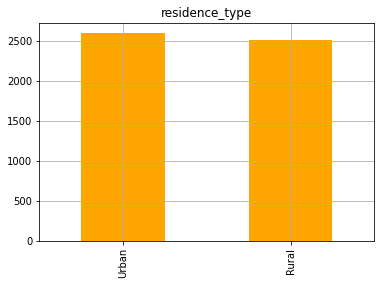

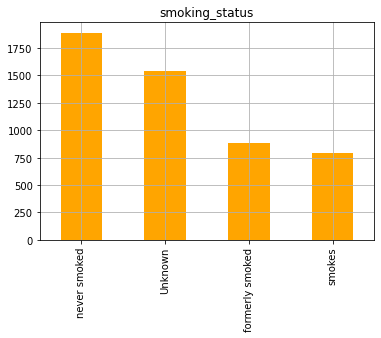

In [13]:
features_cat = ['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status']

for f in features_cat:
    df[f].value_counts().plot(kind='bar',color='orange')
    plt.title(f)
    plt.grid()
    plt.show()

# Target

0    4861
1     249
Name: target, dtype: int64

Percentage of strokes [1]: 4.87 %


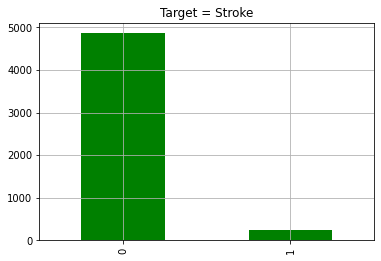

In [14]:
# calc frequencies
target_count = df.target.value_counts()    #most frequent value
print(target_count)
print()
print('Percentage of strokes [1]:', np.round(100*target_count[1] / target_count.sum(),2), '%')


# plot target distribution
target_count.plot(kind='bar',color='Green')
plt.title('Target = Stroke')
plt.grid()
plt.show()

# Target vs Numerical Features

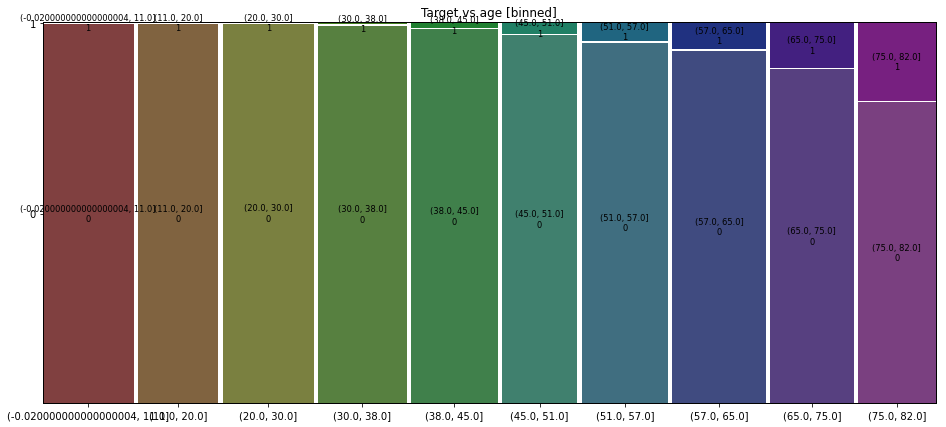

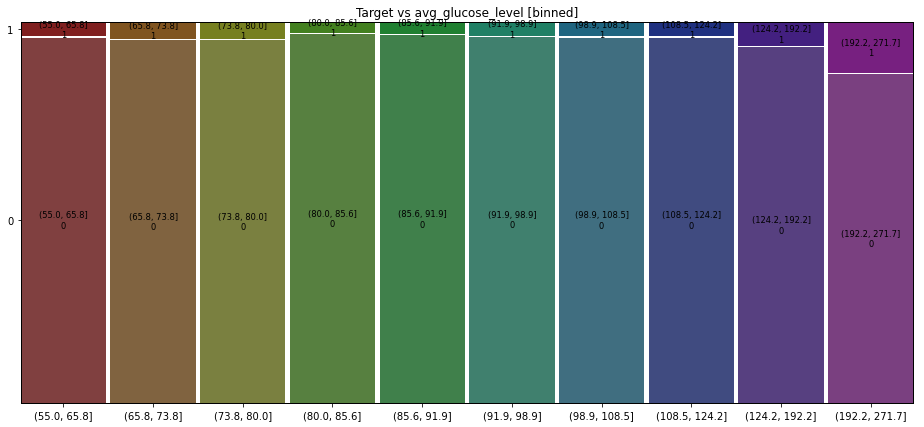

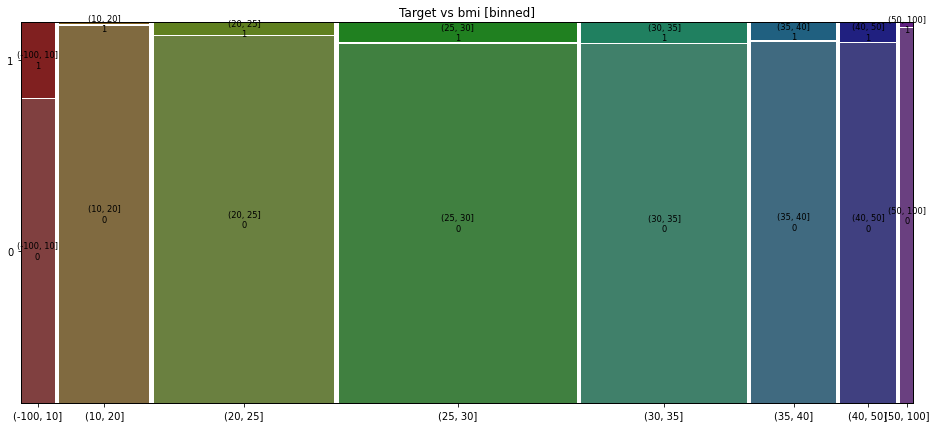

In [15]:
# add binned version of numerical features

# quantile based:
df['age_bin'] = pd.qcut(df['age'], q=10, precision=1)
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# explicitly defined bins:
df['bmi_bin'] = pd.cut(df['bmi'], [-100,10,20,25,30,35,40,50,100])
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_num:
    f_bin = f+'_bin'
    plt.rcParams["figure.figsize"] = (16,7) # increase plot size for mosaics
    mosaic(df, [f_bin, 'target'], title='Target vs ' + f + ' [binned]')
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save


In [16]:
# BMI - check cross table
ctab = pd.crosstab(df.bmi_bin, df.target)
ctab

target,0,1
bmi_bin,,
"(-100, 10]",161,40
"(10, 20]",534,3
"(20, 25]",1035,35
"(25, 30]",1334,75
"(30, 35]",931,54
"(35, 40]",476,24
"(40, 50]",312,17
"(50, 100]",78,1


In [17]:
# normalize each row to get row-wise target percentages
(ctab.transpose() / ctab.sum(axis=1)).transpose()

target,0,1
bmi_bin,,
"(-100, 10]",0.800995,0.199005
"(10, 20]",0.994413,0.005587
"(20, 25]",0.967290,0.032710
"(25, 30]",0.946771,0.053229
"(30, 35]",0.945178,0.054822
"(35, 40]",0.952000,0.048000
"(40, 50]",0.948328,0.051672
"(50, 100]",0.987342,0.012658


# Target vs Categorical Features

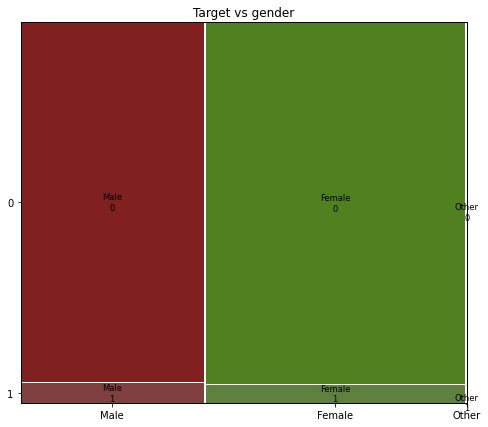

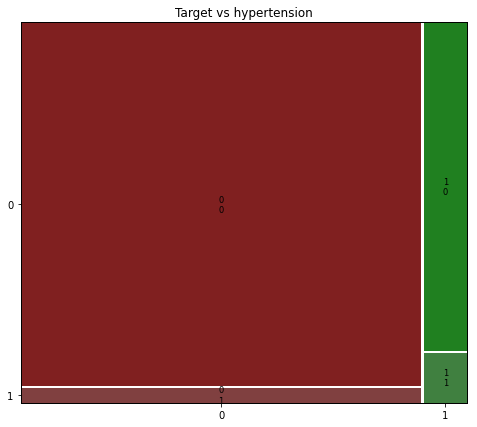

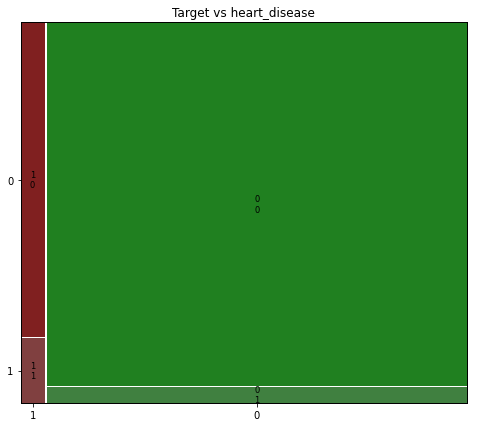

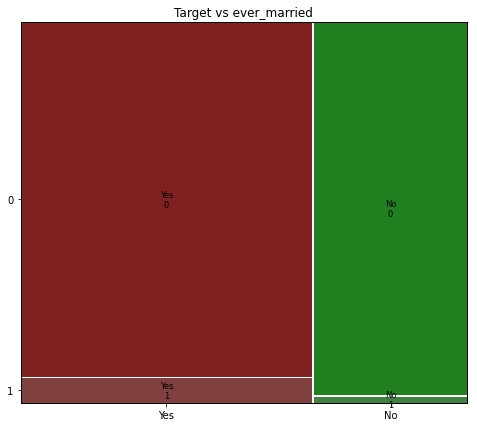

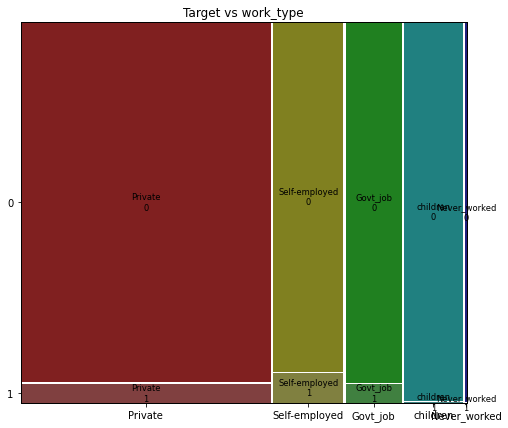

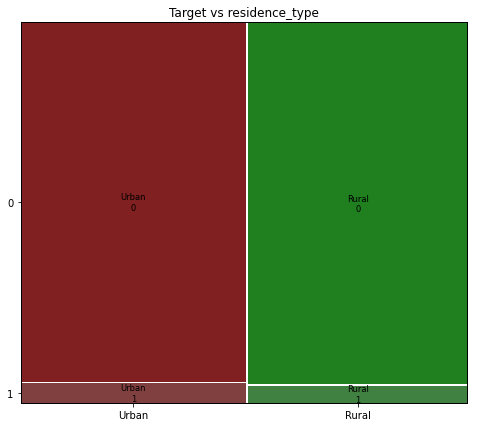

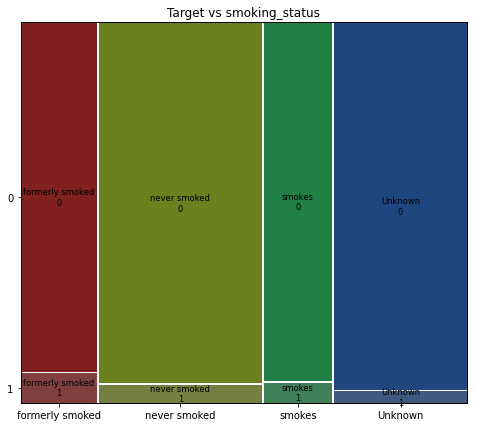

In [18]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_cat:
    plt.rcParams["figure.figsize"] = (8,7) # increase plot size for mosaics
    mosaic(df, [f, 'target'], title='Target vs ' + f)
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

In [19]:
# "ever married" - check cross table
ctab = pd.crosstab(df.ever_married, df.target)
ctab

target,0,1
ever_married,,
No,1728,29
Yes,3133,220


In [20]:
# normalize each row
(ctab.transpose() / ctab.sum(axis=1)).transpose()


target,0,1
ever_married,,
No,0.983495,0.016505
Yes,0.934387,0.065613


# Build Model

In [25]:
# select predictors
predictors = features_num + features_cat
print('Number of predictors: ', len(predictors))
print(predictors)

Number of predictors:  10
['age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']


In [32]:
# start H2O
h2o.init(max_mem_size='12G', nthreads=4) # Use maximum of 12 GB RAM and 4 cores

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.161-b12, mixed mode, sharing)


C:\Users\Tanvir\anaconda3\envs\Hwdre\lib\site-packages\h2o\backend\server.py:385: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\Users\Tanvir\anaconda3\envs\Hwdre\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Tanvir\AppData\Local\Temp\tmpssc1x3sl
  JVM stdout: C:\Users\Tanvir\AppData\Local\Temp\tmpssc1x3sl\h2o_Tanvir_started_from_python.out
  JVM stderr: C:\Users\Tanvir\AppData\Local\Temp\tmpssc1x3sl\h2o_Tanvir_started_from_python.err


H2OServerError: Server process terminated with error code 1: Error: Could not create the Java Virtual Machine.
Error: A fatal exception has occurred. Program will exit.
Invalid maximum heap size: -Xmx12G
The specified size exceeds the maximum representable size.
